#### Libraries

In [52]:
import re,string
import nltk
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.sentiment.util import *
from nltk import tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from collections import Counter
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
import collections

snowballstemmer = SnowballStemmer("english")
stopwords = stopwords.words('english')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#### Tweets cleaning, Tokenization, Stemming and Sentiments Analysis

In [2]:
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def preprocess_word(word):
    word = word.strip('\'"?!,.():;')
    word = re.sub(r'(.)\1+', r'\1\1', word)
    word = re.sub(r'(-|\')', '', word)
    return word

def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

def handle_emojis(tweet):
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

def preprocess_tweet(tweet):
    processed_tweet = []
    tweet = tweet.lower()
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    tweet = tweet.strip(' "\'')
    tweet = handle_emojis(tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):            
            processed_tweet.append(word)
    return ' '.join(processed_tweet)

In [3]:
def tokenization_and_stem(semiclean_tweet):
    total_token_ls = []
    total_snowballstemmer_token_ls = []
    
    for sentence in semiclean_tweet:
        token_ls = []
        snowballstemmer_token_ls = []
        tokensls = nltk.word_tokenize(sentence)
        for token in tokensls:
            if token not in stopwords:
                token_ls.append(token)
                snowballstemmer_token_ls.append(snowballstemmer.stem(token))
        total_token_ls.append(token_ls)
        total_snowballstemmer_token_ls.append(snowballstemmer_token_ls)
    return total_token_ls, total_snowballstemmer_token_ls

def token_join(token_ls): 
    clean_sent_ls = []
    for word_ls in token_ls:
        clean_sent = ""
        for word in word_ls:
            clean_sent += ' '.join(word)
        clean_sent_ls.append(clean_sent)
    return clean_sent_ls

In [4]:
def tweetsCleaning(File):
    df = pd.read_csv(File)    
    cleanedTweet_ls = [0]*len(df["Tweet"]) # Creating List of size of tweets to store processed tweets

    for num, text in enumerate(df["Tweet"]):   
        cleanedTweet = strip_all_entities(strip_links(text))
        cleanedTweet_ls[num] = cleanedTweet            
        
    return(cleanedTweet_ls)

def sentiment_analysis(insert_processed_sentence):
    df = insert_processed_sentence
    sentiment = [0]*len(df)
    for num, tweet in enumerate(df):        
        sentiment[num] = analyzer.polarity_scores(tweet)         
    return sentiment

def assign_sentiments(polarity,df):
    TweetsSentiments = pd.DataFrame()
    senti_token_compound = list()
    i = 0
    for s1 in polarity:        
        sentiment_result = []    

        senti_token_compound.append(s1["compound"])
        if s1["compound"] >= 0.005:
            sentiment_result.append(1) # 1 For positive
        elif s1["compound"] <= -0.005:
            sentiment_result.append(0) # 0 For negative
        else:
            sentiment_result.append("neutral")

        tw_df = pd.DataFrame.from_dict({"Tweet":df["Tweet"][i],                                
                                    "sentiment" :sentiment_result})
        TweetsSentiments = TweetsSentiments.append(tw_df)
        i += 1
    print("Positive Tweets: ",TweetsSentiments[TweetsSentiments["sentiment"] == 1].count()['Tweet'])
    print("Negative Tweets: ",TweetsSentiments[TweetsSentiments["sentiment"] == 0].count()['Tweet'])
    print("Neutral Tweets:  ",TweetsSentiments[TweetsSentiments["sentiment"] == "neutral"].count()['Tweet'])
    
    pos = TweetsSentiments[TweetsSentiments["sentiment"] == 1].count()['Tweet']
    neg = TweetsSentiments[TweetsSentiments["sentiment"] == 0].count()['Tweet']
    neu = TweetsSentiments[TweetsSentiments["sentiment"] == "neutral"].count()['Tweet']
    
    lst = list([pos,neg,neu])
    
    return(TweetsSentiments,lst)

#### Reading Collected data

In [5]:
Boston_Bruins = pd.read_csv("Boston_Bruins.csv") 
Buffalo_Sabres = pd.read_csv("Buffalo_Sabres.csv")  
Detroit_Red_Wings = pd.read_csv("Detroit_Red_Wings.csv") 
Florida_Panthers = pd.read_csv("Florida_Panthers.csv") 
Montreal_Canadiens = pd.read_csv("Montreal_Canadiens.csv")
Ottawa_Senators = pd.read_csv("Ottawa_Senators.csv")
Tampa_Bay_Lightning = pd.read_csv("Tampa_Bay_Lightning.csv")
Toronto_Maple_Leafs = pd.read_csv("Toronto_Maple_Leafs.csv")
Chicago_Blackhawks = pd.read_csv("Chicago_Blackhawks.csv")
Colorado_Avalanche = pd.read_csv("Colorado_Avalanche.csv")
Dallas_Stars = pd.read_csv("Dallas_Stars.csv")
Minnesota_Wild = pd.read_csv("Minnesota_Wild.csv")
Nashville_Predators = pd.read_csv("Nashville_Predators.csv")
St_Louis_Blues = pd.read_csv("St._Louis_Blues.csv")
Winnipeg_Jets = pd.read_csv("Winnipeg_Jets.csv")
Carolina_Hurricanes = pd.read_csv("Carolina_Hurricanes.csv")
Columbus_Blue_Jackets = pd.read_csv("Columbus_Blue_Jackets.csv")
New_Jersey_Devils = pd.read_csv("New_Jersey_Devils.csv")
New_York_Islanders = pd.read_csv("New_York_Islanders.csv")
New_Jersey_Devils = pd.read_csv("New_Jersey_Devils.csv")
New_York_Rangers = pd.read_csv("New_York_Rangers.csv")
Philadelphia_Flyers = pd.read_csv("Philadelphia_Flyers.csv")
Pittsburgh_Penguins = pd.read_csv("Pittsburgh_Penguins.csv")
Washington_Capitals = pd.read_csv("Washington_Capitals.csv")
Anaheim_Ducks = pd.read_csv("Anaheim_Ducks.csv")
Arizona_Coyotes = pd.read_csv("Arizona_Coyotes.csv")
Calgary_Flames = pd.read_csv("Calgary_Flames.csv")
Edmonton_Oilers = pd.read_csv("Edmonton_Oilers.csv")
Los_Angeles_Kings = pd.read_csv("Los_Angeles_Kings.csv")
San_Jose_Sharks = pd.read_csv("San_Jose_Sharks.csv")
Vancouver_Canucks = pd.read_csv("Vancouver_Canucks.csv")
Vegas_Golden_Knights = pd.read_csv("Vegas_Golden_Knights.csv")

In [6]:
AllTeamsTweets = pd.read_csv("AllTeamsTweets")
AllTeamsTweets.shape

(15500, 3)

In [7]:
All_Teams_Dataset_Names_lst = list(["Boston_Bruins", "Buffalo_Sabres","Detroit_Red_Wings","Florida_Panthers","Montreal_Canadiens",
                            "Ottawa_Senators","Tampa_Bay_Lightning","Toronto_Maple_Leafs","Chicago_Blackhawks","Colorado_Avalanche",
                            "Dallas_Stars","Minnesota_Wild","Nashville_Predators","St._Louis_Blues","Winnipeg_Jets","Carolina_Hurricanes",
                            "Columbus_Blue_Jackets","New_Jersey_Devils","New_York_Islanders","New_York_Rangers","Philadelphia_Flyers",
                            "Pittsburgh_Penguins","Washington_Capitals","Anaheim_Ducks","Arizona_Coyotes","Calgary_Flames",
                            "Edmonton_Oilers","Los_Angeles_Kings","San_Jose_Sharks","Vancouver_Canucks","Vegas_Golden_Knights"])
len(All_Teams_Dataset_Names_lst)

31

#### For Each team Seperately

In [8]:
i = 0 
Total_Sentiments_Store = pd.DataFrame()
stat = pd.DataFrame()

for team in All_Teams_Dataset_Names_lst:     
    teamName = team
    team += '.csv'
    statTemp = list()
    pos ,neg ,neu= [],[],[]
    
    df = pd.read_csv(team)    
    SP_cleaned_tweets = [0]*len(df["Tweet"]) # Creating List of size of tweets to store processed tweets

    cleanedTweet_Sentiments_polarity = list()
    Team_Tweets_Sentiments = list()
        
    SP_cleaned_tweets = tweetsCleaning(team) #Specific Team   
    cleanedTweet_Sentiments_polarity = sentiment_analysis(SP_cleaned_tweets) # Cleaned Tweets
    print("\n==> ",i," " ,teamName ," Tweets Sentiments: ")
    Team_Tweets_Sentiments,lstT = assign_sentiments(cleanedTweet_Sentiments_polarity,df)
    
    pos.append(lstT[0])
    neg.append(lstT[1])
    neu.append(lstT[2])
    
    tw_df = pd.DataFrame.from_dict({"Team":All_Teams_Dataset_Names_lst[i],
                                    "positive":pos,
                                    "negative":neg,
                                    "neutral": neu})
    
    stat = stat.append(tw_df)    
    i = i + 1    


==>  0   Boston_Bruins  Tweets Sentiments: 
Positive Tweets:  257
Negative Tweets:  58
Neutral Tweets:   185

==>  1   Buffalo_Sabres  Tweets Sentiments: 
Positive Tweets:  264
Negative Tweets:  94
Neutral Tweets:   142

==>  2   Detroit_Red_Wings  Tweets Sentiments: 
Positive Tweets:  246
Negative Tweets:  131
Neutral Tweets:   123

==>  3   Florida_Panthers  Tweets Sentiments: 
Positive Tweets:  395
Negative Tweets:  48
Neutral Tweets:   57

==>  4   Montreal_Canadiens  Tweets Sentiments: 
Positive Tweets:  139
Negative Tweets:  285
Neutral Tweets:   76

==>  5   Ottawa_Senators  Tweets Sentiments: 
Positive Tweets:  186
Negative Tweets:  168
Neutral Tweets:   146

==>  6   Tampa_Bay_Lightning  Tweets Sentiments: 
Positive Tweets:  234
Negative Tweets:  84
Neutral Tweets:   182

==>  7   Toronto_Maple_Leafs  Tweets Sentiments: 
Positive Tweets:  90
Negative Tweets:  38
Neutral Tweets:   372

==>  8   Chicago_Blackhawks  Tweets Sentiments: 
Positive Tweets:  280
Negative Tweets:  34


In [9]:
stat.to_csv("TeamStatistics.csv",index=False)

#### Teams Tweets Sentiment Statistics
Each team and their Number of Positive, Negative and Neutral Tweets count. 
Assignng Clusters using k-mean clustering to Teams into 3 different cluster 0, 1 and 2.

In [10]:
TeamStats = pd.read_csv("TeamStatistics.csv")
TeamStats_Original=TeamStats
TeamStats

,Team,positive,negative,neutral
0,Boston_Bruins,257,58,185
1,Buffalo_Sabres,264,94,142
2,Detroit_Red_Wings,246,131,123
3,Florida_Panthers,395,48,57
4,Montreal_Canadiens,139,285,76
5,Ottawa_Senators,186,168,146
6,Tampa_Bay_Lightning,234,84,182
7,Toronto_Maple_Leafs,90,38,372
8,Chicago_Blackhawks,280,34,186
9,Colorado_Avalanche,301,48,151


In [11]:
#TeamStats.sort_values(by=['positive'], ascending=False)
ts = TeamStats[['positive','negative']]
dataset_array = ts.values
km = KMeans(3).fit(dataset_array)
lb = km.labels_
TeamStatsCluster = TeamStats
TeamStatsCluster['Cluster'] = lb
#TeamStatsCluster.sort_values(by=['Cluster'], ascending=True)

#### Cluster 0
Montreal Canadiens,Ottawa Senators, New York Islanders, New Jersey Devils, Vancouver Canucks

#### Cluster 1
Boston Bruins,
San Jose Sharks,
Los Angeles Kings,
Edmonton Oilers,
Calgary Flames,
Arizona Coyotes,
Anaheim Ducks,
Washington Capitals,
New York Rangers,
Columbus Blue Jackets,
Carolina Hurricanes,
St. Louis Blues,
Nashville Predators,
Minnesota Wild,
Dallas Stars,
Toronto Maple Leafs,
Tampa Bay Lightning,
Detroit Red Wings,
Buffalo Sabres,
Winnipeg Jets

#### Cluster 3
Philadelphia Flyers, Pittsburgh Penguins, Colorado Avalanche, Chicago Blackhawks, Florida Panthers, Vegas Golden Knights

In [12]:
negative_data = stat["negative"].tolist()
negative_data_minus = [i * -1 for i in negative_data]
positive_data = stat["positive"].tolist()

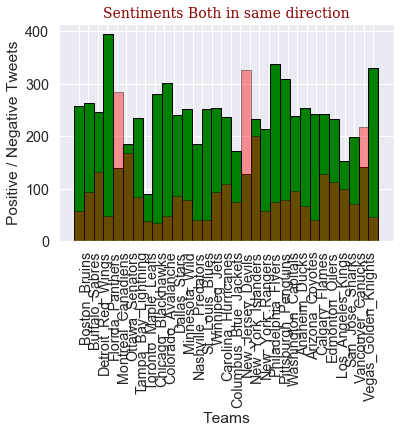

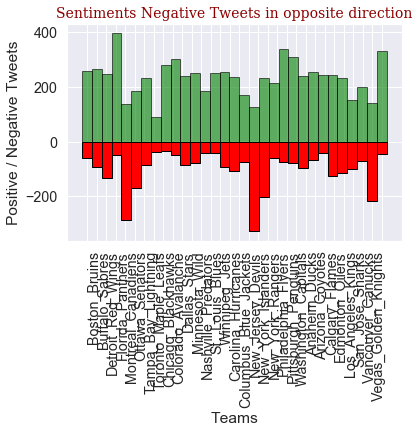

In [13]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

x = range(31)
fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Teams')
plt.ylabel('Positive / Negative Tweets')

vals = stat['Team'].tolist()
n, bins, patches = plt.hist(vals, stat['Team'].unique().__len__(), stacked=True, density=False)

plt.xticks(ticks=bins, labels=stat['Team'], rotation=90, horizontalalignment='left')
plt.title("Sentiments Both in same direction", fontdict= font, loc='center')
ax.bar(x, positive_data, width=1,alpha=1, color='b',facecolor='green', edgecolor='black')
ax.bar(x, negative_data, width=1, alpha=0.4,color='r',facecolor='red', edgecolor='black')
plt.show()

ax = plt.subplot(111)
plt.xlabel('Teams')
plt.ylabel('Positive / Negative Tweets')

vals = stat['Team'].tolist()
n, bins, patches = plt.hist(vals, stat['Team'].unique().__len__(), stacked=True, density=False)

plt.xticks(ticks=bins, labels=stat['Team'], rotation=90, horizontalalignment='left')
plt.title("Sentiments Negative Tweets in opposite direction", fontdict= font, loc='center')
ax.bar(x, positive_data, width=1,alpha=0.6, color='b',facecolor='green', edgecolor='black')
ax.bar(x, negative_data_minus,alpha=1, width=1, color='r',facecolor='red', edgecolor='black')

plt.show()

### Data Analysis

In [14]:
def item_count(tweet):
    result = {}
    result['MENTIONS'] = tweet.count('USER_MENTION')
    result['URLS'] = tweet.count('URL')
    result['POS_EMOS'] = tweet.count('EMO_POS')
    result['NEG_EMOS'] = tweet.count('EMO_NEG')
    tweet = tweet.replace('USER_MENTION', '').replace(
        'URL', '')
    words = tweet.split()
    result['WORDS'] = len(words)
    bigrams = get_bigrams(words)
    result['BIGRAMS'] = len(bigrams)
    return result, words, bigrams

def get_bigrams(tweet_words):
    bigrams = []
    num_words = len(tweet_words)
    for i in range(num_words - 1):
        bigrams.append((tweet_words[i], tweet_words[i + 1]))
    return bigrams

def get_bigram_freqdist(bigrams):
    freq_dict = {}
    for bigram in bigrams:
        if freq_dict.get(bigram):
            freq_dict[bigram] += 1
        else:
            freq_dict[bigram] = 1
    counter = Counter(freq_dict)
    return counter

In [15]:
AllTeamsTweets_processedTweets = [0]*len(AllTeamsTweets["Tweet"])    # Creating List of size of tweets to store processed tweets
for num, text in enumerate(AllTeamsTweets["Tweet"]):
    AllTeamsTweets_processedTweets[num] = preprocess_tweet(text)

In [16]:
num_tweets = 0
num_mentions, max_mentions = 0, 0
num_emojis, num_pos_emojis, num_neg_emojis, max_emojis = 0, 0, 0, 0
num_urls, max_urls = 0, 0
num_words, num_unique_words, min_words, max_words = 0, 0, 1e6, 0
num_bigrams, num_unique_bigrams = 0, 0
all_words = []
all_bigrams = []

for i, line in enumerate(AllTeamsTweets_processedTweets):
    num_tweets = num_tweets + 1
    tweet = line.strip().split(',')
    tweet = " ".join(str(x) for x in tweet)
    result, words, bigrams = item_count(tweet)
    num_mentions += result['MENTIONS']
    max_mentions = max(max_mentions, result['MENTIONS'])
    num_pos_emojis += result['POS_EMOS']
    num_neg_emojis += result['NEG_EMOS']
    max_emojis = max(
        max_emojis, result['POS_EMOS'] + result['NEG_EMOS'])
    num_urls += result['URLS']
    max_urls = max(max_urls, result['URLS'])
    num_words += result['WORDS']
    min_words = min(min_words, result['WORDS'])
    max_words = max(max_words, result['WORDS'])
    all_words.extend(words)
    num_bigrams += result['BIGRAMS']
    all_bigrams.extend(bigrams)    

In [17]:
num_emojis = num_pos_emojis + num_neg_emojis
unique_words = list(set(all_words))
num_unique_words = len(unique_words)
num_unique_bigrams = len(set(all_bigrams))

# Bigrams
bigram_freq_dist = get_bigram_freqdist(all_bigrams)

print('\nAnalysis Statistics \n')
print('Tweets        => Total: {0}\n'.format(num_tweets))
print('User Mentions => Total: {0},\tAvg: {1},Max: {2} \n'.format(num_mentions, num_mentions / float(num_tweets), max_mentions))
print('URLs          => Total: {0},\tAvg: {1},Max: {2} \n'.format(num_urls, num_urls / float(num_tweets), max_urls))
print('Emojis        => Total: {0},\tPositive: {1},\t\tNegative: {2},Avg: {3}, Max: {4} \n'.format(num_emojis, num_pos_emojis, num_neg_emojis, num_emojis / float(num_tweets), max_emojis))
print('Words         => Total: {0},\tUnique: {1},\t\tAvg: {2}, Max: {3}, Min: {4} \n'.format(num_words, num_unique_words, num_words / float(num_tweets), max_words, min_words))
print('Bigrams       => Total: {0},\tUnique: {1},\t\tAvg: {2} \n'.format(num_bigrams, num_unique_bigrams, num_bigrams / float(num_tweets)))

#### All Tweets tokenization, Stemming and Sentiment Anaysis 

In [18]:
df_T = AllTeamsTweets
token_ls = [0]*len(df_T["Tweet"])    # Creating List of size of tweets to store processed tweets
snowstemmer_token_ls = [0]*len(df_T["Tweet"])
cleanedTweet_ls = [0]*len(df_T["Tweet"])

for num, text in enumerate(df_T["Tweet"]):   
    cleanedTweet = strip_all_entities(strip_links(text))
    cleanedTweet_ls[num] = cleanedTweet    
    token_ls[num], snowstemmer_token_ls[num] = tokenization_and_stem(strip_all_entities(strip_links(text))) 

In [19]:
sentence_tokenized = [0]*len(df_T["Tweet"])
for num, token in enumerate(token_ls):
    sentence_tokenized[num] = token_join(token)

sentence_snowstemmeed = [0]*len(df_T["Tweet"])
for num, token in enumerate(snowstemmer_token_ls):
    sentence_snowstemmeed[num] = token_join(token)

In [20]:
originalTweets_Sentiments_polarity = sentiment_analysis(df_T["Tweet"]) # Origninal Tweets
cleanedTweet_Sentiments_polarity = sentiment_analysis(cleanedTweet_ls) # Cleaned Tweets

In [21]:
AllTweets_sentiments_Cleaned, lstT = assign_sentiments(cleanedTweet_Sentiments_polarity,df_T)
print("----------------------------------")
AllTweets_sentiments_Original = assign_sentiments(originalTweets_Sentiments_polarity,df_T)

Positive Tweets:  7238
Negative Tweets:  3125
Neutral Tweets:   5137
----------------------------------
Positive Tweets:  7092
Negative Tweets:  3098
Neutral Tweets:   5310


In [22]:
# removing neutral tweets
AllTweets_sentiments_Cleaned = AllTweets_sentiments_Cleaned[AllTweets_sentiments_Cleaned.sentiment != "neutral"]
print("Positive & Negative Tweets",AllTweets_sentiments_Cleaned.shape) # only positve and negative tweets 

Positive & Negative Tweets (10363, 2)


In [23]:
AllTweets_sentiments_Cleaned.to_csv("AllTweets_sentiments_Cleaned.csv",index= False)
AllTweets_sentiments_Cleaned.shape

(10363, 2)

In [24]:
AllTweets_sentiments_Cleaned = pd.read_csv("AllTweets_sentiments_Cleaned.csv")
print("Positive & Negative Tweets",AllTweets_sentiments_Cleaned.shape) # only positve and negative tweets 

Positive & Negative Tweets (10363, 2)


In [25]:
AllTweets_sentiments_Cleaned_pos = AllTweets_sentiments_Cleaned[AllTweets_sentiments_Cleaned.sentiment == 1]
AllTweets_sentiments_Cleaned_pos.shape

(7238, 2)

In [26]:
AllTweets_sentiments_Cleaned_neg = AllTweets_sentiments_Cleaned[AllTweets_sentiments_Cleaned.sentiment == 0]
AllTweets_sentiments_Cleaned_neg.shape

(3125, 2)

In [27]:
AllTweets_sentiments_Cleaned_pos = AllTweets_sentiments_Cleaned_pos[:3125]

In [28]:
AllTweets_sentiments_Cleaned = pd.concat([AllTweets_sentiments_Cleaned_pos,AllTweets_sentiments_Cleaned_neg])
print("Number of Tweets and columns: ", AllTweets_sentiments_Cleaned.shape)

Number of Tweets and columns:  (6250, 2)


In [29]:
AllTweets_sentiments_Cleaned = AllTweets_sentiments_Cleaned.sample(frac=1) # Randomizing Dataframe rows
AllTweets_sentiments_Cleaned.shape

(6250, 2)

In [30]:
TweetsSentiments_Tweets = AllTweets_sentiments_Cleaned.Tweet  # only tweets
TweetsSentiments_sentiments = AllTweets_sentiments_Cleaned.sentiment # only sentiments

#### Data Analysis

In [31]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X
    
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
     
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls                           
                          })
        
        return df

In [32]:
from nltk.corpus import stopwords

ct = CleanText()
sr_clean = ct.fit_transform(AllTweets_sentiments_Cleaned.Tweet)

tc = TextCounts()
df_eda = tc.fit_transform(AllTweets_sentiments_Cleaned.Tweet)
df_eda['sentiment'] = AllTweets_sentiments_Cleaned.sentiment

In [33]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    g.savefig(col + '_dist.png')

In [ ]:
show_dist(df_eda,"count_words")

Descriptive stats for count_mentions
------------------------------------
            count     mean       std  min  25%  50%  75%   max
sentiment                                                     
0          3125.0  0.93088  0.874132  0.0  0.0  1.0  1.0  11.0
1          3125.0  1.03616  1.061628  0.0  0.0  1.0  1.0  14.0


C:\Users\Fahad Hameed\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


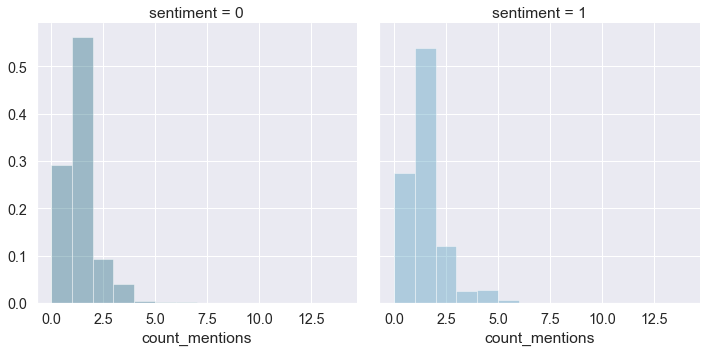

In [34]:
show_dist(df_eda,"count_mentions")

Descriptive stats for count_hashtags
------------------------------------
            count     mean       std  min  25%  50%  75%   max
sentiment                                                     
0          3125.0  0.47424  1.251782  0.0  0.0  0.0  0.0  15.0
1          3125.0  0.54304  1.444831  0.0  0.0  0.0  1.0  16.0


C:\Users\Fahad Hameed\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


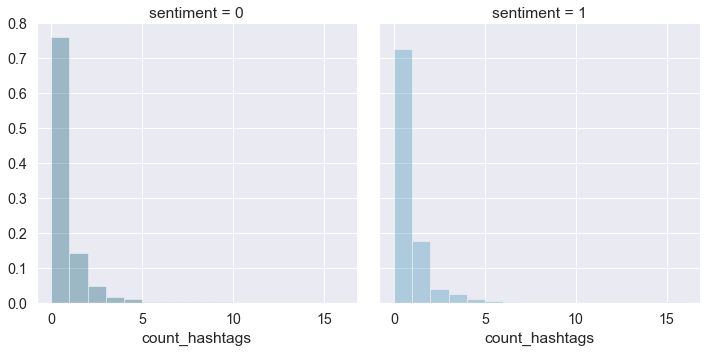

In [35]:
show_dist(df_eda,"count_hashtags")

Descriptive stats for count_capital_words
-----------------------------------------
            count     mean       std  min  25%  50%  75%   max
sentiment                                                     
0          3125.0  1.80448  3.623950  0.0  0.0  1.0  2.0  21.0
1          3125.0  1.77664  2.779227  0.0  0.0  1.0  2.0  39.0


C:\Users\Fahad Hameed\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


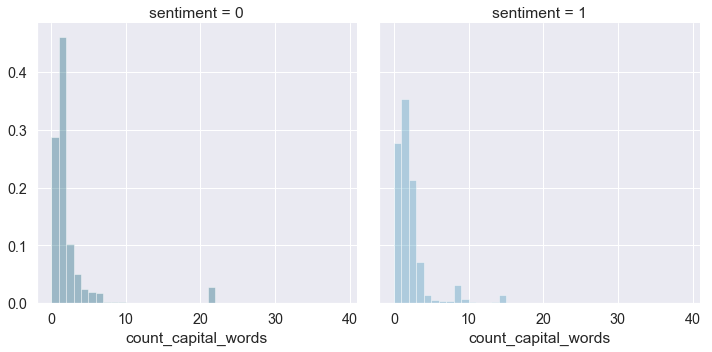

In [36]:
show_dist(df_eda,"count_capital_words")

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count     mean       std  min  25%  50%  75%  max
sentiment                                                    
0          3125.0  0.29376  0.838481  0.0  0.0  0.0  0.0  8.0
1          3125.0  0.43520  0.965163  0.0  0.0  0.0  0.0  9.0


C:\Users\Fahad Hameed\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


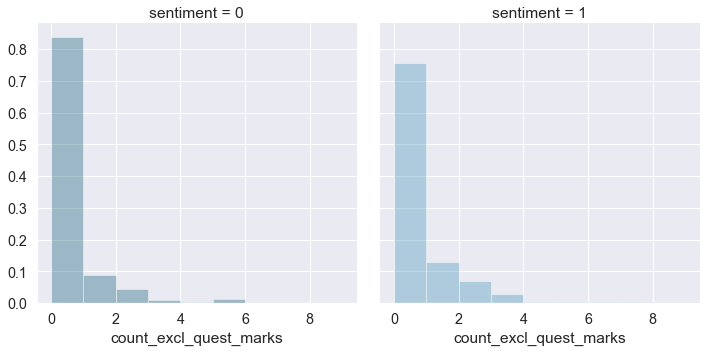

In [37]:
show_dist(df_eda,"count_excl_quest_marks")

Descriptive stats for count_urls
--------------------------------
            count     mean       std  min  25%  50%  75%  max
sentiment                                                    
0          3125.0  0.45600  0.688575  0.0  0.0  0.0  1.0  4.0
1          3125.0  0.53792  0.659501  0.0  0.0  0.0  1.0  4.0


C:\Users\Fahad Hameed\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


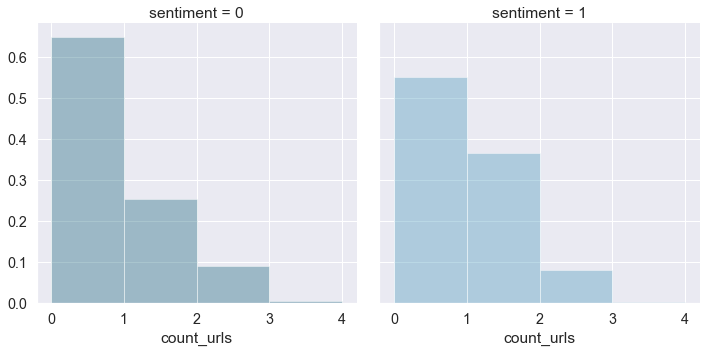

In [38]:
show_dist(df_eda,"count_urls")

#### Most Frequent words

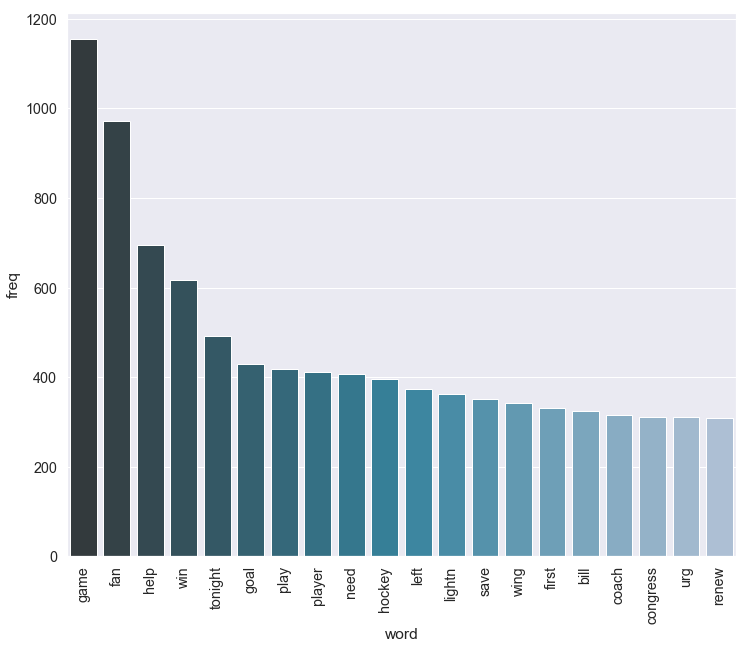

In [39]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)

words_to_remove = ('Boston','jersey','Bruin','Bruins', 'Buffalo', 'Sabres','Detroit', 'Red', 'Wings','Florida', 'Panther','Panthers','Montreal', 'Canadiens','Canadien','Ottawa', 'Senators','Tampa', 'Bay', 'Lightning','Toronto', 'Maple' ,'Leafs','Chicago', 'Blackhawks','Colorado' ,'Avalanche',
                            'Dallas', 'Stars','Minnesota', 'Wild','Nashville', 'Predators','St', 'Louis' ,'Blue','Blues','Winnipeg' ,'Jet','Jets','Carolina', 'Hurricane','Hurricanes',
                            'Columbus', 'Blue', 'Jackets','New', 'Jersey' ,'Devil','Devils','New', 'York' ,'Islander','Islanders','New' ,'York', 'Rangers','Philadelphia', 'Flyers',
                            'Pittsburgh' ,'Penguins','Washington', 'Capitals','Anaheim', 'Ducks','Arizona', 'Coyotes','Calgary', 'Flames','Flame','nhl','team','teams','rt',
                            'Edmonton', 'Oilers','Los', 'Angeles', 'Kings','San' 'Jose', 'Sharks','Vancouver', 'Canucks','Vegas', 'Golden', 'the','go','Knights','blackhawks')
words_to_remove = [x.lower() for x in words_to_remove]

for k in words_to_remove:
    word_counter.pop(k, None)

word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
aa = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)

aa.set_xticklabels(aa.get_xticklabels(), rotation=90)
plt.show();

##### NHL General Trend 

In [40]:
trend = pd.read_csv("NHLTrend.csv")
NHL_Teams = pd.read_csv("NHL_Teams")
TeamStatsCluster = pd.read_csv("TeamStatistics.csv")

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
rankings = [93,69,58,72,79,52,108,78,67,72,75,74,83,79,84,81,79,59,85,68,74,83,89,63,73,91,67,58,90,65,81]
NHL_Teams["rankings"] = rankings #PTS
TeamStatsCluster["rankings"] = rankings

In [48]:
TeamStatsCluster['positive'] = np.log(TeamStatsCluster.positive)
TeamStatsCluster['negative'] = np.log(TeamStatsCluster.negative)
TeamStatsCluster['rankings'] = np.log(TeamStatsCluster.rankings)

In [50]:
TeamStatsCluster

,Team,positive,negative,neutral,rankings
0,Boston_Bruins,5.549076,4.060443,185,4.532599
1,Buffalo_Sabres,5.575949,4.543295,142,4.234107
2,Detroit_Red_Wings,5.505332,4.875197,123,4.060443
3,Florida_Panthers,5.978886,3.871201,57,4.276666
4,Montreal_Canadiens,4.934474,5.652489,76,4.369448
5,Ottawa_Senators,5.225747,5.123964,146,3.951244
6,Tampa_Bay_Lightning,5.455321,4.430817,182,4.682131
7,Toronto_Maple_Leafs,4.499810,3.637586,372,4.356709
8,Chicago_Blackhawks,5.634790,3.526361,186,4.204693
9,Colorado_Avalanche,5.707110,3.871201,151,4.276666


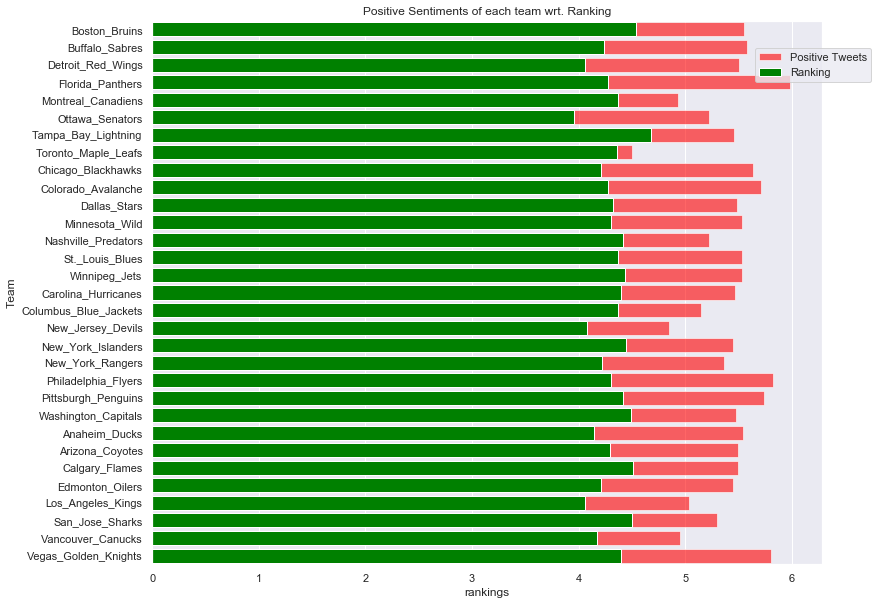

In [51]:
fig, ax = plt.subplots()
ax.set_title('Positive Sentiments of each team wrt. Ranking')
sns.set(rc={'figure.figsize':(12,10)})

sns.barplot(x = "positive", y = "Team", label="Positive Tweets",facecolor='red',
            alpha = 0.6, data = TeamStatsCluster)  # Lighter
sns.barplot(x = "rankings", y = "Team",facecolor='green',label="Ranking",
            alpha = 1, data = TeamStatsCluster)   # Darker
ax.legend(bbox_to_anchor=(0.9, 0.95), loc=2, borderaxespad=0.)